<a href="https://colab.research.google.com/github/MaggusCoding/DataMining/blob/main/DM-Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To-Dos: 
- Korrelationsanalyses

In [2]:
## Datensatz 'San Francisco Crime Classification' von Kaggle
## Datensatzbeschreibung:
# Datum                         - Zeitpunkt der Straftat
# Kategorie                     - Kategorie der Straftat (nur in Trainingsdaten), Zielvariable
# Beschreibung                  - detaillierte Beschreibung der Straftat (nur in Trainingsdaten)
# Tag der Woche
# 'District' der Polizeistation - Name des 'Districts' der Polizeistation
# Auflösung                     - Ergebniss der Straftat
# Adresse                       - geschätzte Adresse der Straftat
# X                             - Long
# Y                             - Lat

In [38]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# Import der Pakete
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime as dt
import matplotlib.pyplot as plt

In [5]:
# Einlesen der Trainings- und Testdaten
train = pd.read_csv("/content/drive/MyDrive/Master/DM/SF-Project/data/train.csv")
test  = pd.read_csv("/content/drive/MyDrive/Master/DM/SF-Project/data/test.csv")

In [6]:
# Pauls Kasten
#train = pd.read_csv("/content/drive/MyDrive/Uni/Master/2.Semester/DataMining/Data/train.csv")
#test  = pd.read_csv("/content/drive/MyDrive/Uni/Master/2.Semester/DataMining/Data/test.csv")

In [7]:
# Übersicht über Kopf der Trainingsdaten
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [8]:
# Datentypen ermitteln
train.dtypes

Dates          object
Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object

In [9]:
train.shape

(878049, 9)

# **Datenvorverarbeitung**
- Trennung der Datenspalte
- NA Behandlung
- Duplikate entfernen
- Einschränkung der Kategorien

In [10]:
## Datenformatierung - Dates
# Umwandeln in Datumformat
train['Dates'] = pd.to_datetime(train['Dates'])
# Trennung von Datum und Uhrzeit
train['Date'] = train['Dates'].dt.strftime('%Y-%m-%d')
train['Date'] = pd.to_datetime(train['Date'])

train['Time'] = train['Dates'].dt.strftime('%H:%M')
train['Hour'] = pd.to_datetime(train['Dates'], format='%H:%M').dt.hour

In [11]:
# Jahr, Monat, Tag extrahieren
train['Year']  = train['Dates'].dt.strftime('%Y').astype(int)
train['Month'] = train['Dates'].dt.strftime('%m').astype(int)
train['Day']   = train['Dates'].dt.strftime('%d').astype(int)

In [12]:
# Variable WeekOfYear anlegen
train['WeekOfYear'] = pd.to_datetime(train['Date']).dt.isocalendar().week.astype(int)

In [13]:
# Variable Dates löschen
train = train.drop('Dates',axis=1)

In [14]:
## NA Behandlung
# Übersicht über NA in Spalten
train.isna().sum()
# keine NA's ersichtlich 

Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
Date          0
Time          0
Hour          0
Year          0
Month         0
Day           0
WeekOfYear    0
dtype: int64

In [15]:
# Ausgabe eindeutiger Werte für relevanten Spalten
train_uniq = train.loc[:,['Category','PdDistrict','Resolution','Address']]
for col in train_uniq:
  print(train_uniq[col].value_counts())

LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

In [16]:
# Augenscheinlich keine fehlerhaften/uneindeutige Werte enthalten

In [17]:
## Duplikate
# Anzahl der Duplikate
dup_rows = train.duplicated()
print('Anzahl an duplizierten Zeilen:',sum(dup_rows))

Anzahl an duplizierten Zeilen: 2323


In [18]:
# Entfernen der Duplikate
train        = train.drop_duplicates()
dup_rows_new = train.duplicated()
print('Anzahl an duplizierten Zeilen:',sum(dup_rows_new))

Anzahl an duplizierten Zeilen: 0


In [19]:
## Datenformatierung - Category
# Übersicht über Verbrechenskategorien
train['Category'].unique()

array(['WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
       'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
       'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS',
       'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY',
       'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
       'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
       'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT',
       'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS', 'BRIBERY',
       'EMBEZZLEMENT', 'SUICIDE', 'LOITERING',
       'SEX OFFENSES NON FORCIBLE', 'EXTORTION', 'GAMBLING', 'BAD CHECKS',
       'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'],
      dtype=object)

In [20]:
# Filtern der benötigten Kategorien
imp_cat   = ['LARCENY/THEFT','ASSAULT','DRUG/NARCOTIC','VEHICLE THEFT','BURGLARY']
train_sub = train[train['Category'].isin(imp_cat)]

In [21]:
train_sub['Category'].unique()

array(['LARCENY/THEFT', 'VEHICLE THEFT', 'ASSAULT', 'BURGLARY',
       'DRUG/NARCOTIC'], dtype=object)

# **Deskriptive Analyse**


Text(0.5, 1.0, 'Correlation Heatmap')

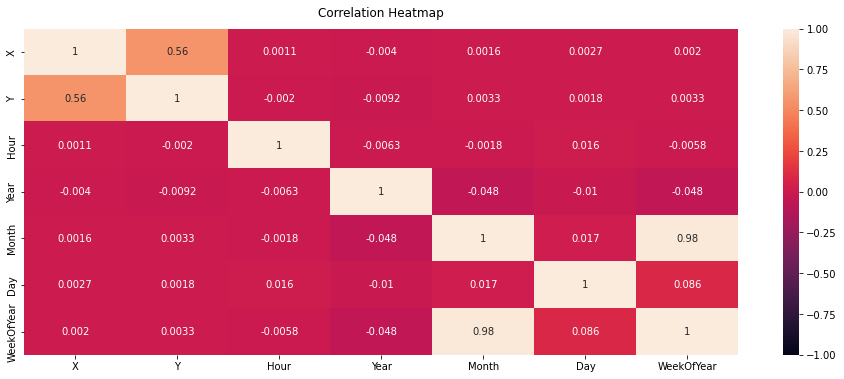

In [22]:
## Korrelationsanalyse Heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(train.corr(), vmin=-1,vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [23]:
from scipy.stats import chi2_contingency

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

train_cat = train[['Category','Descript','PdDistrict','Resolution']]

Korrelationsanalyse von nominal kategorischen Merkmalen, ohne Addresse aufgrund des geringen Rams in Colab. 
Description und Category sind hoch korreliert, was jedoch nicht weiter verwunderlich ist. Der Rest ist unauffällig.

In [24]:
rows= []

for var1 in train_cat:
  col = []
  for var2 in train_cat :
    cramers =cramers_V(train_cat[var1], train_cat[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = train_cat.columns, index =train_cat.columns)



df

,Category,Descript,PdDistrict,Resolution
Category,1.00,0.99,0.02,0.09
Descript,0.99,1.00,0.03,0.16
PdDistrict,0.02,0.03,1.00,0.01
Resolution,0.09,0.16,0.01,1.00


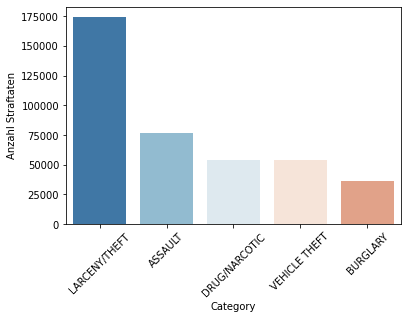

In [25]:
## Verteilung Straftaten
sns.set_palette('RdBu_r')
sns.countplot(x='Category',
              data=train_sub,
              order = train_sub['Category'].value_counts().index)
plt.ylabel('Anzahl Straftaten')
plt.xticks(rotation=45)
plt.show()

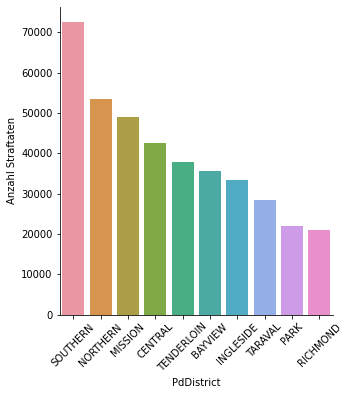

In [26]:
## Anzahl der Straftaten je Revier
sns.set_palette('RdBu_r')
k = sns.catplot(x='PdDistrict',
            data=train_sub,
            order=train_sub['PdDistrict'].value_counts().index,
            kind='count')
k.set_ylabels('Anzahl Straftaten')
plt.xticks(rotation=45)
plt.show()

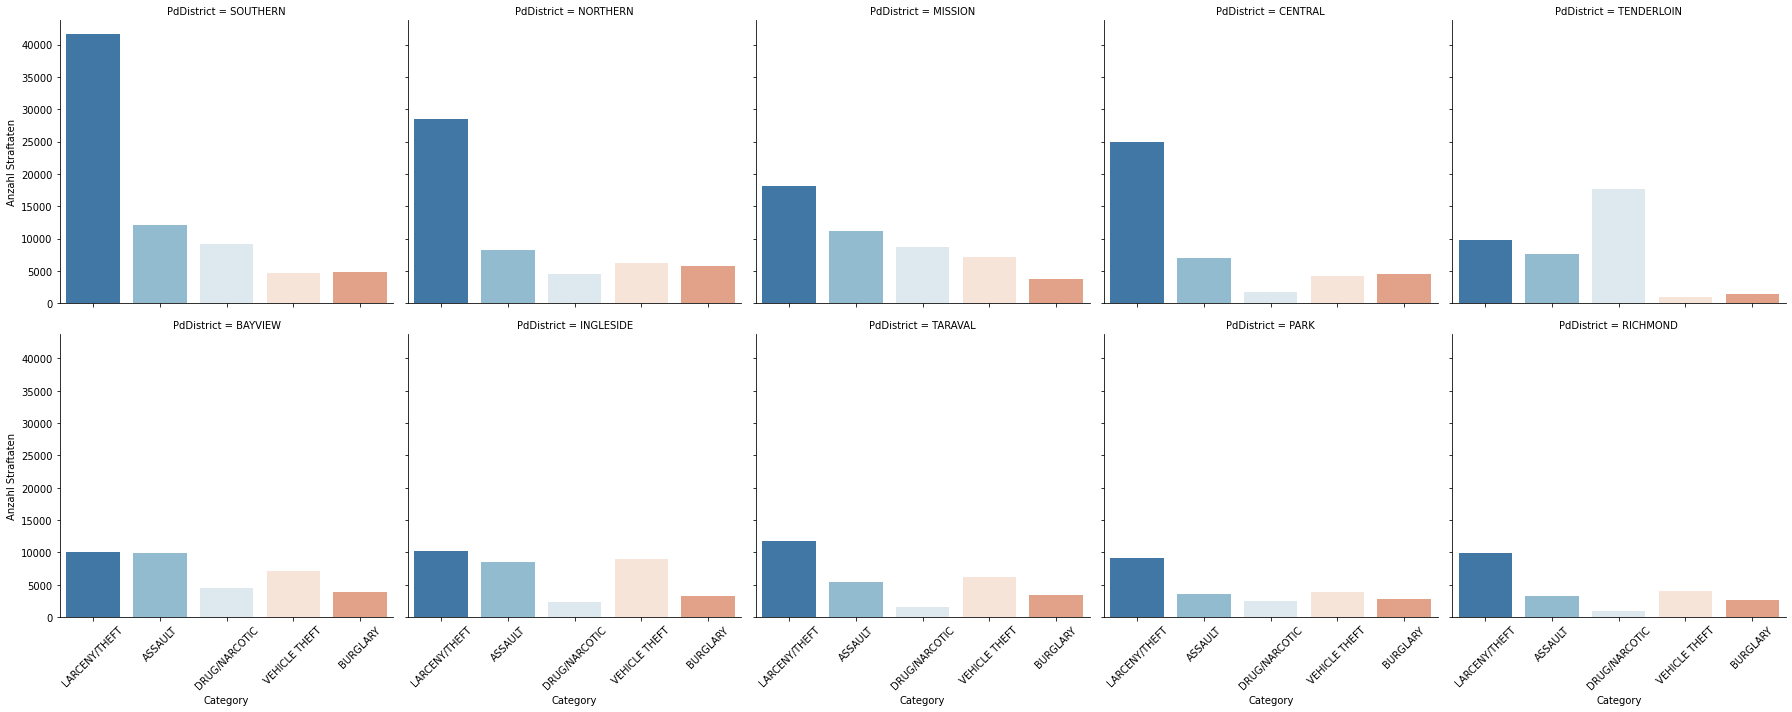

In [27]:
## Verteilung der Straftatsarten je Revier
sns.set_palette('RdBu_r')
g = sns.catplot(x='Category',
              data=train_sub,
            kind='count',
              order = train_sub['Category'].value_counts().index,
            col='PdDistrict',
            col_wrap=5,
            col_order=train_sub['PdDistrict'].value_counts().index)
g.set_ylabels('Anzahl Straftaten')
for ax in g.axes:
    plt.setp(ax.get_xticklabels(), visible=True, rotation=45)
g.tight_layout()
plt.show()

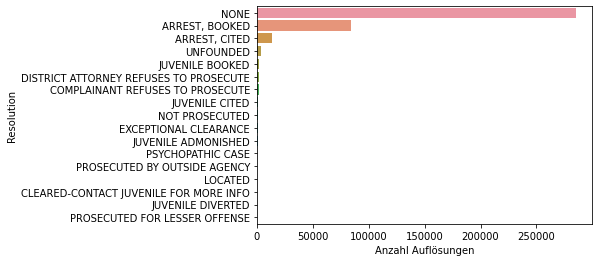

In [28]:
## Verteilung Auflösungen
sns.set_palette('RdBu_r')
sns.countplot(y='Resolution',
              data=train_sub,
              order = train_sub['Resolution'].value_counts().index)
plt.xlabel('Anzahl Auflösungen')
#plt.xticks(rotation=90)
plt.show()

In [29]:
## Zusammenführen der geringen Resolution Ausprägungen
top_res = train_sub.groupby(['Resolution']).size().reset_index(name='counts')
top_res = top_res.sort_values(by='counts',ascending=False)
top_res_names = top_res.iloc[0:4,0].tolist()
top_res_names

['NONE', 'ARREST, BOOKED', 'ARREST, CITED', 'UNFOUNDED']

In [30]:
## Alle Ausprägungen mit geringer Anzahl werden zusammengefasst
train_sub_red = train_sub
train_sub_red['Resolution'].mask(~train_sub_red['Resolution'].isin(top_res_names), 'OTHER', inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [31]:
train_sub_red.groupby('Resolution').size()

Resolution
ARREST, BOOKED     83907
ARREST, CITED      13426
NONE              285260
OTHER               9155
UNFOUNDED           3612
dtype: int64

([0, 1, 2, 3, 4], <a list of 5 Text major ticklabel objects>)

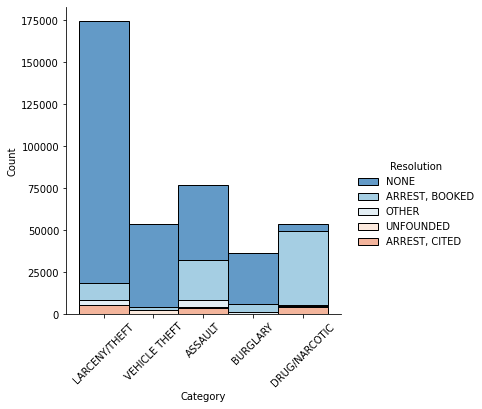

In [32]:
sns.displot(train_sub, x='Category', hue='Resolution', multiple='stack')
plt.xticks(rotation=45)

# **Feature Engineering**

1. Boolean Feature Sonne untergegangen 
2. Boolean Feature Wochenende/Feiertag 

In [43]:
#Sonnenauf -und untergänge in San Francisco auf monatlicher Basis
sunset = pd.read_csv("/content/drive/MyDrive/Master/DM/SF-Project/data/SunsetSF.csv",delimiter =';')
print(sunset.head())
train = pd.merge(train,sunset,how='inner', on = 'Month')
print(train.head())


   Month   Rise   Culm    Set
0      1  07:22  12:11  17:00
1      2  07:12  12:21  17:31
2      3  06:40  12:20  18:01
3      4  06:54  13:12  19:31
4      5  06:13  13:05  19:58
         Category                      Descript  DayOfWeek PdDistrict  \
0        WARRANTS                WARRANT ARREST  Wednesday   NORTHERN   
1  OTHER OFFENSES      TRAFFIC VIOLATION ARREST  Wednesday   NORTHERN   
2  OTHER OFFENSES      TRAFFIC VIOLATION ARREST  Wednesday   NORTHERN   
3   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO  Wednesday   NORTHERN   
4   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO  Wednesday       PARK   

       Resolution                    Address           X          Y  \
0  ARREST, BOOKED         OAK ST / LAGUNA ST -122.425892  37.774599   
1  ARREST, BOOKED         OAK ST / LAGUNA ST -122.425892  37.774599   
2  ARREST, BOOKED  VANNESS AV / GREENWICH ST -122.424363  37.800414   
3            NONE   1500 Block of LOMBARD ST -122.426995  37.800873   
4            NONE  100 Blo